In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from embedding_functions import *
from experiment_setup import *
import numba as nb
from tqdm import tqdm

In [2]:
def gaussian_ellipse(cluster):
    """Stolen from Ian"""

    mean = np.mean(cluster, axis=0)
    cov = np.cov(cluster.T)

    if mean.shape == (1, 2):
        mean = np.array(mean)[0]
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    rtheta = np.arctan2(u[1], u[0])
    v = 3.0 * np.sqrt(2.0) * np.sqrt(v)
    width = v[0]
    height = v[1]

    R = np.array(
        [
            [np.cos(rtheta), -np.sin(rtheta)],
            [np.sin(rtheta), np.cos(rtheta)],
        ]
    )
    theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
    x = 0.5 * width * np.cos(theta)
    y = 0.5 * height * np.sin(theta)
    x, y = np.dot(R, np.array([x, y]))
    x += mean[0]
    y += mean[1]

    return [x, y]



In [3]:
# n = 1000
# d = 2

# B = np.array([[0.5, 0.05], [0.05, 0.1]])
# As, tau, Ps = sbm_from_B(n, [B], return_p=True)
# true_P = Ps[0].copy()


n = 500
T = 2
d = 2
As, tau, _ = make_iid(n, T)



obs_A = As[0].copy().astype(float)

In [4]:
# Estimate P

s, w = np.linalg.eig(obs_A)
s = np.real(s)
idx = np.abs(s).argsort()[::-1]
s = s[idx]
s = np.abs(s)
X_hat = np.real(w)[:, :d] @ np.diag(np.sqrt(s[:d]))

# X_hat = single_spectral(obs_A, d=d)

P_hat = X_hat @ X_hat.T

In [5]:
# Sigmoid the P_hat
# P_hat = 1 / (1 + np.exp(-P_hat))

# print(np.min(P_hat))
# print(np.max(P_hat))

In [6]:
# align with observed
P_hat_rot = procrust_align(obs_A, P_hat)
P_hat = P_hat_rot.copy()

In [7]:
print(np.min(P_hat))
print(np.max(P_hat))

-0.011444557731360524
0.6476412192702449


In [8]:
# bootstrap
s = 10
A_star = [make_inhomogeneous_rg(P_hat) for _ in range(s)]

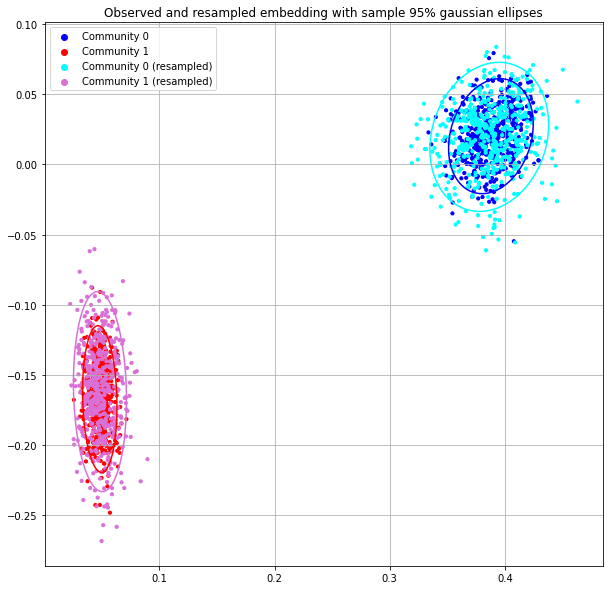

In [9]:
"""
Embed and visualise the difference between the observed and resampled embedding time points

Notice that the variance of the resampled embeddings is larger than the observed embedding 
"""
T = s + 1
A_star_with_obs = np.array([obs_A] + A_star)

ya_star = UASE(A_star_with_obs, d, flat=False)

# plot_embedding(ya_star.reshape((n * T, d)), n, T, tau)

time_1 = 0
time_2 = 2

plt.figure(figsize=(10, 10))
plt.scatter(
    ya_star[time_1, :, 0],
    ya_star[time_1, :, 1],
    c=np.where(tau == 0, "blue", "red"),
    s=10,
)
ellipse_obs_0 = gaussian_ellipse(
    ya_star[time_1, np.where(tau == 0)].reshape((int(n / 2), d))
)
ellipse_obs_1 = gaussian_ellipse(
    ya_star[time_1, np.where(tau == 1)].reshape((int(n / 2), d))
)
plt.plot(ellipse_obs_0[0], ellipse_obs_0[1], c="blue")
plt.plot(ellipse_obs_1[0], ellipse_obs_1[1], c="red")
plt.scatter(
    ya_star[time_2, :, 0],
    ya_star[time_2, :, 1],
    c=np.where(tau == 0, "cyan", "orchid"),
    s=10,
)
ellipse_obs_0 = gaussian_ellipse(
    ya_star[time_2, np.where(tau == 0)].reshape((int(n / 2), d))
)
ellipse_obs_1 = gaussian_ellipse(
    ya_star[time_2, np.where(tau == 1)].reshape((int(n / 2), d))
)
plt.plot(ellipse_obs_0[0], ellipse_obs_0[1], c="cyan")
plt.plot(ellipse_obs_1[0], ellipse_obs_1[1], c="orchid")

# plt.xlim(-0.6, 0.6)
# plt.ylim(-0.6, 0.6)

plt.grid()

# legend
plt.title("Observed and resampled embedding with sample 95% gaussian ellipses")
plt.scatter([], [], c="blue", label="Community 0")
plt.scatter([], [], c="red", label="Community 1")
plt.scatter([], [], c="cyan", label="Community 0 (resampled)")
plt.scatter([], [], c="orchid", label="Community 1 (resampled)")
_ = plt.legend()


In [9]:
# Quantify the extra dispursion seen in the bootstrapped embeddings
# covs = np.zeros((n, d, d))
# for i in range(n):
#     # The difference between the positions of node i in bootstrapped embeddings vs the observed
#     epsilons = np.array([ya_star[0, i, :] - ya_star[t, i, :] for t in range(1, s + 1)])

#     covs[i] = np.cov(epsilons.T)

# # Covariance of the extra dispersion
# # %%
# # sample delta hat from mean 0 normal with covariance cov
# delta_hat = np.array(
#     [np.random.multivariate_normal(np.zeros(d), covs[i], size=1)[0] for i in range(n)]
# )

In [10]:
# A_true = [make_inhomogeneous_rg(true_P) for _ in range(s + 1)]
# ya_true = UASE(A_true, d, flat=False)
# covs_true = np.zeros((n, d, d))
# for i in range(n):
#     # The difference between the positions of node i in bootstrapped embeddings vs the observed
#     epsilons_true = np.array(
#         [ya_true[0, i, :] - ya_true[t, i, :] for t in range(1, s + 1)]
#     )

#     covs_true[i] = np.cov(epsilons_true.T)


In [11]:
"""
Get delta hat by computing the sample variance of the bootstrapped embeddings

[Really, what we're computing here is delta_hat + bootstrap noise]
"""
delta_hat = np.zeros((n, d))
for i in range(n):
    # Mean-center all the bootstrapped positions for node i
    node_positions = ya_star[1:, i, :]
    node_positions = node_positions - np.mean(node_positions, axis=0)

    # Compute sample variance
    cov = np.cov(node_positions.T)
    delta_hat[i, :] = np.diagonal(cov)

In [12]:
delta_true = np.zeros((n, d))
A_true = [make_inhomogeneous_rg(true_P) for _ in range(s)]
ya_true = UASE(A_true, d, flat=False)
for i in range(n):
    # Get mean-centred node positions in the true resampled case
    node_positions = ya_true[:, i, :]
    node_positions = node_positions - np.mean(node_positions, axis=0)

    # Get the true variances
    cov = np.cov(node_positions.T)
    delta_true[i, :] = np.diagonal(cov)


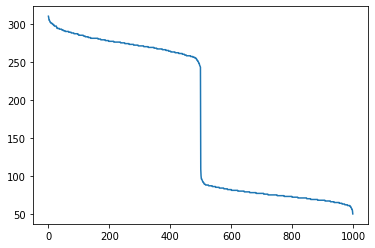

In [13]:
degrees = np.sum(obs_A, axis=0)
idx = np.argsort(degrees)[::-1]
plt.plot(degrees[idx])

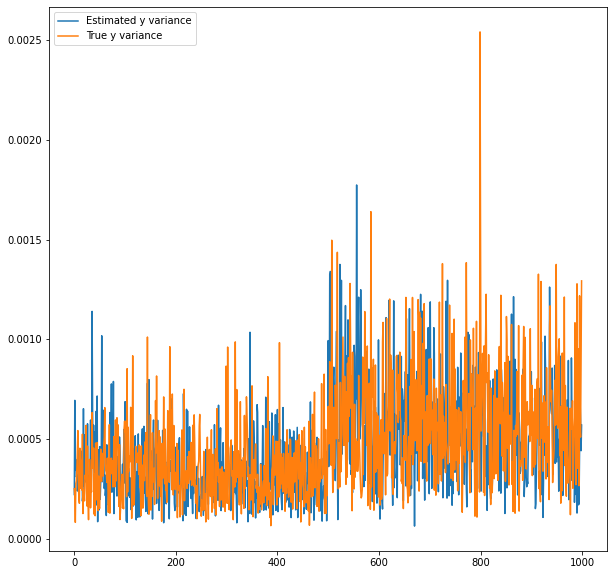

In [14]:
plt.figure(figsize=(10, 10))

# plt.plot(delta_hat[idx, 0], label="Estimated x variance")
# plt.plot(delta_true[idx, 0], label="True x variance")

plt.plot(delta_hat[idx, 1], label="Estimated y variance")
plt.plot(delta_true[idx, 1], label="True y variance")

plt.legend()

# plt.plot(np.linalg.norm(delta_hat[idx,:], axis=1))


In [15]:
# node = 25
# plt.figure()
# plt.scatter(ya_star[1:, node, 0], ya_star[1:, node, 1], c="red")
# plt.scatter(ya_star[0, node, 0], ya_star[0, node, 1], c="black", s=200)

# ya_true_rot = procrust_align(ya_star.reshape((n * T, d)), ya_true.reshape((n * T, d)))
# ya_true_rot = ya_true_rot.reshape((T, n, d))
# plt.scatter(ya_true_rot[1:, node, 0], ya_true_rot[1:, node, 1], c="blue")

# # %%
# # Scatter ya_star[0] and colour by magnitude of delta_hat
# plt.figure()
# plt.scatter(ya_star[0, :, 0], ya_star[0, :, 1], c=np.linalg.norm(delta_hat, axis=1))
# # plt.scatter(ya_star[0, :, 0], ya_star[0, :, 1], c=degrees)


In [16]:
# ya_true_flat = UASE(A_true, d, flat=True)
# plot_embedding(ya_true_flat, n, s, tau)
ya_star_flat = UASE(A_star_with_obs, d, flat=True)
plot_embedding(ya_star_flat, n, s + 1, tau)


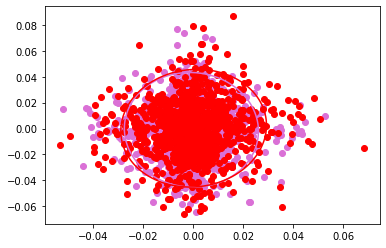

In [17]:

delta_hat_sample = np.array(
    [
        np.random.multivariate_normal(np.zeros(d), cov=np.diag(delta_hat[i]), size=1)[0]
        for i in range(n)
    ]
)

plt.figure()
plt.scatter(delta_hat_sample[:, 0], delta_hat_sample[:, 1], c="orchid")

ellipse = gaussian_ellipse(delta_hat_sample)
plt.plot(ellipse[0], ellipse[1], c="orchid")

delta_true_sample = np.array(
    [
        np.random.multivariate_normal(np.zeros(d), cov=np.diag(delta_true[i]), size=1)[
            0
        ]
        for i in range(n)
    ]
)

plt.scatter(delta_true_sample[:, 0], delta_true_sample[:, 1], c="red")

ellipse_true = gaussian_ellipse(delta_true_sample)
plt.plot(ellipse_true[0], ellipse_true[1], c="red")



In [18]:
def plot_data(ya_star, tau, time_1, time_2, n, d):
    plt.figure(figsize=(10, 10))
    plt.scatter(
        ya_star[time_1, :, 0],
        ya_star[time_1, :, 1],
        c=np.where(tau == 0, "blue", "red"),
        s=10,
    )
    ellipse_obs_0 = gaussian_ellipse(
        ya_star[time_1, np.where(tau == 0)].reshape((int(n / 2), d))
    )
    ellipse_obs_1 = gaussian_ellipse(
        ya_star[time_1, np.where(tau == 1)].reshape((int(n / 2), d))
    )
    plt.plot(ellipse_obs_0[0], ellipse_obs_0[1], c="blue")
    plt.plot(ellipse_obs_1[0], ellipse_obs_1[1], c="red")
    plt.scatter(
        ya_star[time_2, :, 0],
        ya_star[time_2, :, 1],
        c=np.where(tau == 0, "cyan", "orchid"),
        s=10,
    )
    ellipse_obs_0 = gaussian_ellipse(
        ya_star[time_2, np.where(tau == 0)].reshape((int(n / 2), d))
    )
    ellipse_obs_1 = gaussian_ellipse(
        ya_star[time_2, np.where(tau == 1)].reshape((int(n / 2), d))
    )
    plt.plot(ellipse_obs_0[0], ellipse_obs_0[1], c="cyan")
    plt.plot(ellipse_obs_1[0], ellipse_obs_1[1], c="orchid")

    plt.xlim(-0.6, 0.6)
    plt.ylim(-0.6, 0.6)

    plt.grid()

    # legend
    plt.scatter([], [], c="blue", label="Community 0")
    plt.scatter([], [], c="red", label="Community 1")
    plt.scatter([], [], c="cyan", label="Community 0 (resampled)")
    plt.scatter([], [], c="orchid", label="Community 1 (resampled)")
    _ = plt.legend()



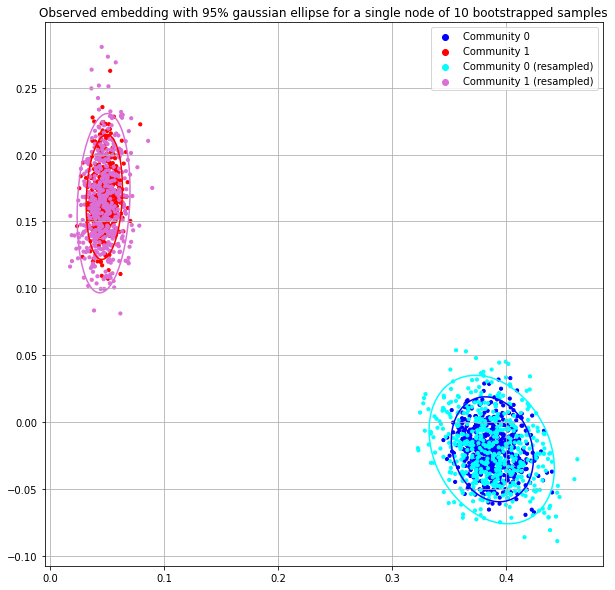

In [29]:
"""
Plot the observed embedding and 95% gaussian ellipses for each community
Also plot the ellipse of one of the bootstrapped samples 
"""

time_1 = 0  # observed
time_2 = 2  # bootstrapped

plt.figure(figsize=(10, 10))
plt.scatter(
    ya_star[time_1, :, 0],
    ya_star[time_1, :, 1],
    c=np.where(tau == 0, "blue", "red"),
    s=10,
)

# ya_true_rot = procrust_align(ya_star[1:].reshape(n * s, d), ya_true.reshape(n * s, d))
# ya_true_rot = ya_true_rot.reshape((s, n, d))

# plt.scatter(ya_true_rot[:, node, 0], ya_true_rot[:, node, 1], c="purple", s=5, alpha=1)

# plt.scatter(ya_star[time_1, :, 0], ya_star[time_1, :, 1], c="black", s=200)

ellipse_obs_0 = gaussian_ellipse(
    ya_star[time_1, np.where(tau == 0)].reshape((int(n / 2), d))
)
ellipse_obs_1 = gaussian_ellipse(
    ya_star[time_1, np.where(tau == 1)].reshape((int(n / 2), d))
)
plt.plot(ellipse_obs_0[0], ellipse_obs_0[1], c="blue")
plt.plot(ellipse_obs_1[0], ellipse_obs_1[1], c="red")
plt.scatter(
    ya_star[time_2, :, 0],
    ya_star[time_2, :, 1],
    c=np.where(tau == 0, "cyan", "orchid"),
    # c="orchid",
    s=10,
)
ellipse_obs_0 = gaussian_ellipse(ya_star[time_2, np.where(tau==0), :].reshape((int(n / 2), d)))
ellipse_obs_1 = gaussian_ellipse(
    ya_star[time_2, np.where(tau == 1)].reshape((int(n / 2), d))
)
plt.plot(ellipse_obs_0[0], ellipse_obs_0[1], c="cyan")
plt.plot(ellipse_obs_1[0], ellipse_obs_1[1], c="orchid")

# plt.xlim(-0.6, 0.6)
# plt.ylim(-0.6, 0.6)

plt.grid()

# legend
plt.title(
    "Observed embedding with 95% gaussian ellipse for a single node of {} bootstrapped samples".format(
        s
    )
)
plt.scatter([], [], c="blue", label="Community 0")
plt.scatter([], [], c="red", label="Community 1")
plt.scatter([], [], c="cyan", label="Community 0 (resampled)")
plt.scatter([], [], c="orchid", label="Community 1 (resampled)")
# plt.scatter([], [], c="orchid", label="Resampled node {}".format(node))
_ = plt.legend()

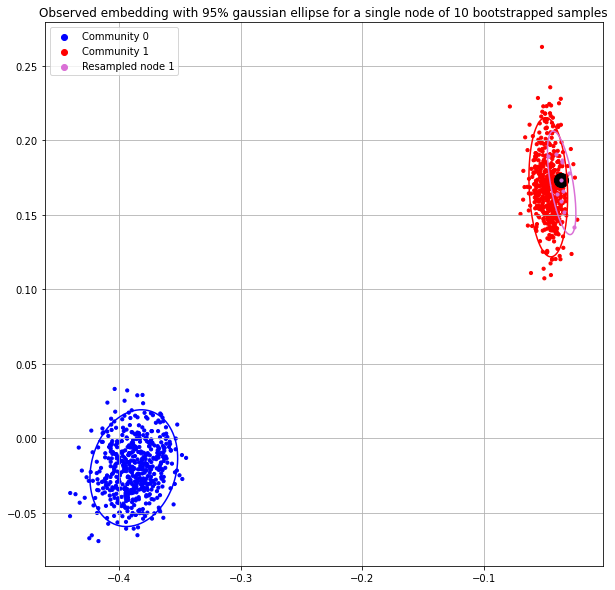

In [19]:
"""
Plot the observed embedding and 95% gaussian ellipses for each community
Also plot the ellipse computed the s boostrapped positions for a single node 
"""

time_1 = 0  # observed
time_2 = 2  # bootstrapped

node = 1  # select single node to plot variance

plt.figure(figsize=(10, 10))
plt.scatter(
    ya_star[time_1, :, 0],
    ya_star[time_1, :, 1],
    c=np.where(tau == 0, "blue", "red"),
    s=10,
)

# ya_true_rot = procrust_align(ya_star[1:].reshape(n * s, d), ya_true.reshape(n * s, d))
# ya_true_rot = ya_true_rot.reshape((s, n, d))

# plt.scatter(ya_true_rot[:, node, 0], ya_true_rot[:, node, 1], c="purple", s=5, alpha=1)

plt.scatter(ya_star[time_1, node, 0], ya_star[time_1, node, 1], c="black", s=200)

ellipse_obs_0 = gaussian_ellipse(
    ya_star[time_1, np.where(tau == 0)].reshape((int(n / 2), d))
)
ellipse_obs_1 = gaussian_ellipse(
    ya_star[time_1, np.where(tau == 1)].reshape((int(n / 2), d))
)
plt.plot(ellipse_obs_0[0], ellipse_obs_0[1], c="blue")
plt.plot(ellipse_obs_1[0], ellipse_obs_1[1], c="red")
plt.scatter(
    # ya_star[time_2, :, 0],
    # ya_star[time_2, :, 1],
    ya_star[:, node, 0],
    ya_star[:, node, 1],
    # c=np.where(tau == 0, "cyan", "orchid"),
    c="orchid",
    s=10,
)
ellipse_obs_0 = gaussian_ellipse(ya_star[:, node, :])
# ellipse_obs_1 = gaussian_ellipse(
#     ya_star[:, np.where(tau == 1)].reshape((int(n / 2), d))
# )
plt.plot(ellipse_obs_0[0], ellipse_obs_0[1], c="orchid")
# plt.plot(ellipse_obs_1[0], ellipse_obs_1[1], c="orchid")

# plt.xlim(-0.6, 0.6)
# plt.ylim(-0.6, 0.6)

plt.grid()

# legend
plt.title(
    "Observed embedding with 95% gaussian ellipse for a single node of {} bootstrapped samples".format(
        s
    )
)
plt.scatter([], [], c="blue", label="Community 0")
plt.scatter([], [], c="red", label="Community 1")
# plt.scatter([], [], c="cyan", label="Community 0 (resampled)")
# plt.scatter([], [], c="orchid", label="Community 1 (resampled)")
plt.scatter([], [], c="orchid", label="Resampled node {}".format(node))
_ = plt.legend()
